In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import Cityscapes
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor
from torchmetrics import Dice
from torchmetrics.classification import MulticlassJaccardIndex

In [2]:
label_map = {
    0 : ['unlabeled', 19, 'void'], 
    1 : ['ego vehicle', 19, 'void'],
    2 : ['rectification border', 19, 'void'],
    3 : ['out of roi', 19, 'void'],
    4 : ['static', 19, 'void'],
    5 : ['dynamic', 19, 'void'],
    6 : ['ground', 19, 'void'],
    7 : ['road', 0, 'flat'],
    8 : ['sidewalk', 1, 'flat'],
    9 : ['parking', 19, 'flat'],
    10 : ['rail track', 19, 'flat'],
    11 : ['building', 2, 'construction'],
    12 : ['wall', 3, 'construction'],
    13 : ['fence', 4, 'construction'],
    14 : ['guard rail', 19, 'construction'],
    15 : ['bridge', 19, 'construction'],
    16 : ['tunnel', 19, 'construction'],
    17 : ['pole', 5, 'object'],
    18 : ['polegroup', 19, 'object'],
    19 : ['traffic light', 6, 'object'],
    20 : ['traffic sign', 7, 'object'],
    21 : ['vegetation', 8, 'nature'],
    22 : ['terrain', 9, 'nature'],
    23 : ['sky', 10, 'sky'],
    24 : ['person', 11, 'human'],
    25 : ['rider', 12, 'human'],
    26 : ['car', 13, 'vehicle'],
    27 : ['truck', 14, 'vehicle'],
    28 : ['bus', 15, 'vehicle'],
    29 : ['caravan', 19, 'vehicle'],
    30 : ['trailer', 19, 'vehicle'],
    31 : ['train', 16, 'vehicle'],
    32 : ['motorcycle', 17, 'vehicle'],
    33 : ['bicycle', 18, 'vehicle'],
    34 : ['license plate', -1, 'vehicle']
}

In [3]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        encx = torch.zeros(x.shape, dtype=torch.long)
        for label in label_map:
            encx[x == label] = label_map[label][1]
        onehot = F.one_hot(encx.squeeze(1), 20).permute(0, 3, 1, 2)[0].float()
        return onehot[:-1]

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 512)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 512)),
        transforms.PILToTensor(), 
        MakeClass()
    ]
)

train_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "train", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform
)

valid_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "val", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform    
)

test_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "test", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 2975
#Validation Samples: 500
#Testing Samples: 1525
#Training Batch: 93
#Validation Batch: 16
#Testing Batch: 48


data shape: torch.Size([3, 256, 512])
mask shape: torch.Size([19, 256, 512])
Number classes: 19
Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])


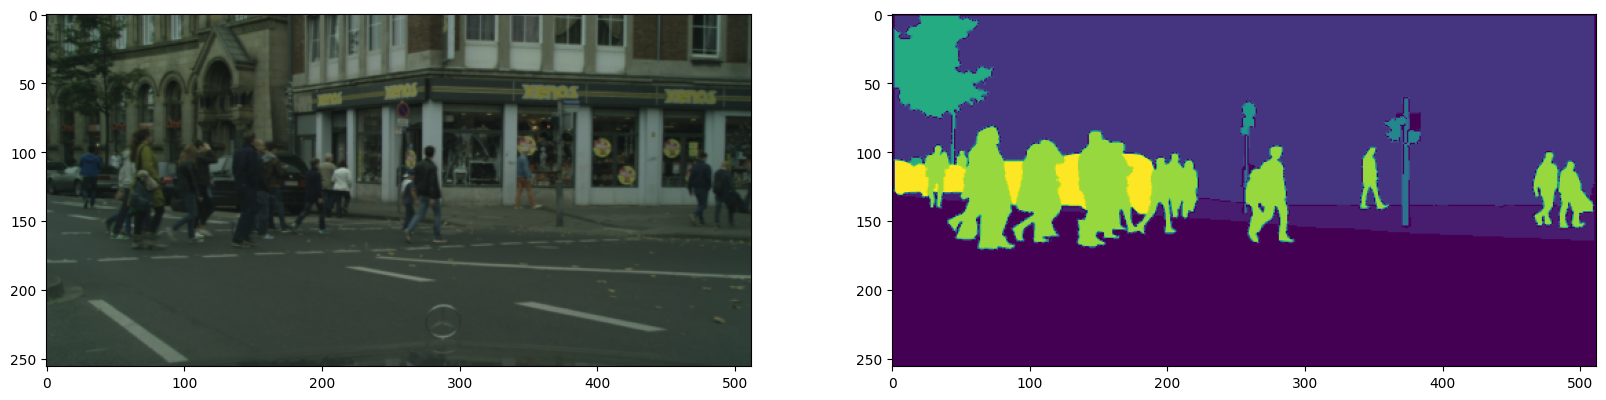

In [5]:
sample_data, sample_mask = train_ds[19]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, num_class, True).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

metric_dice = Dice().to(device)
metric_iou = MulticlassJaccardIndex(num_classes=num_class).to(device)

In [13]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        train_dice = metric_dice(train_gen_mask, train_mask.to(dtype=torch.uint8))
        train_iou = metric_iou(train_gen_mask.argmax(1), train_mask.argmax(1).to(dtype=torch.uint8))
        
        tr_total_loss += train_loss.cpu().item()
        tr_total_dice += train_dice
        tr_total_iou += train_iou

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        va_total_dice = 0
        va_total_iou = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            valid_rec_loss = loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = valid_rec_loss + valid_dice_loss
            valid_dice = metric_dice(valid_gen_mask, valid_mask.to(dtype=torch.uint8))
            valid_iou = metric_iou(valid_gen_mask.argmax(1), valid_mask.argmax(1).to(dtype=torch.uint8))
            
            va_total_loss += valid_loss.cpu().item()
            va_total_dice += valid_dice
            va_total_iou += valid_iou
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_train_dice = tr_total_dice/len(train_dl)
    mean_train_iou = tr_total_iou/len(train_dl)

    mean_valid_loss = va_total_loss/len(valid_dl)
    mean_valid_dice = va_total_dice/len(valid_dl)
    mean_valid_iou = va_total_iou/len(valid_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
    print(f"Epoch: {epoch} - TrainDice: {mean_train_dice} - TrainIOU: {mean_train_iou}")
    print(f"Epoch: {epoch} - ValidDice: {mean_valid_dice} - ValidIOU: {mean_valid_iou}")
model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.08it/s]


Epoch: 0 - TrainLoss: 1.752469470424037 - ValidLoss: 1.1637963727116585
Epoch: 0 - TrainDice: 0.6306228041648865 - TrainIOU: 0.14926165342330933
Epoch: 0 - ValidDice: 0.6567212343215942 - ValidIOU: 0.17335867881774902


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 1 - TrainLoss: 0.9812753206940108 - ValidLoss: 0.960327748209238
Epoch: 1 - TrainDice: 0.6793535947799683 - TrainIOU: 0.1965453177690506
Epoch: 1 - ValidDice: 0.6776582598686218 - ValidIOU: 0.1970837116241455


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 2 - TrainLoss: 0.80741657428844 - ValidLoss: 0.8298359103500843
Epoch: 2 - TrainDice: 0.7122765183448792 - TrainIOU: 0.22101396322250366
Epoch: 2 - ValidDice: 0.6921781301498413 - ValidIOU: 0.22113831341266632


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


Epoch: 3 - TrainLoss: 0.7361745212667732 - ValidLoss: 0.8771343939006329
Epoch: 3 - TrainDice: 0.7211018204689026 - TrainIOU: 0.23863132297992706
Epoch: 3 - ValidDice: 0.7123344540596008 - ValidIOU: 0.20460107922554016


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.07it/s]


Epoch: 4 - TrainLoss: 0.6971920632546947 - ValidLoss: 0.7465413622558117
Epoch: 4 - TrainDice: 0.7174750566482544 - TrainIOU: 0.24812164902687073
Epoch: 4 - ValidDice: 0.6981350183486938 - ValidIOU: 0.23538601398468018


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.15it/s]


Epoch: 5 - TrainLoss: 0.6579404857850844 - ValidLoss: 0.7252250984311104
Epoch: 5 - TrainDice: 0.7142150402069092 - TrainIOU: 0.25988641381263733
Epoch: 5 - ValidDice: 0.7000129818916321 - ValidIOU: 0.24963025748729706


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 6 - TrainLoss: 0.6262264520891251 - ValidLoss: 0.6889240369200706
Epoch: 6 - TrainDice: 0.7109265923500061 - TrainIOU: 0.269879013299942
Epoch: 6 - ValidDice: 0.6775210499763489 - ValidIOU: 0.25598645210266113


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 7 - TrainLoss: 0.5987326557277352 - ValidLoss: 0.6941726021468639
Epoch: 7 - TrainDice: 0.712468683719635 - TrainIOU: 0.28119370341300964
Epoch: 7 - ValidDice: 0.6834294199943542 - ValidIOU: 0.26283353567123413


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


Epoch: 8 - TrainLoss: 0.584089252256578 - ValidLoss: 0.6690051965415478
Epoch: 8 - TrainDice: 0.7117986083030701 - TrainIOU: 0.28973326086997986
Epoch: 8 - ValidDice: 0.7098228931427002 - ValidIOU: 0.27359065413475037


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 9 - TrainLoss: 0.56225874379117 - ValidLoss: 0.6403255797922611
Epoch: 9 - TrainDice: 0.7182883620262146 - TrainIOU: 0.305013507604599
Epoch: 9 - ValidDice: 0.7128819823265076 - ValidIOU: 0.2893722355365753


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.08it/s]


Epoch: 10 - TrainLoss: 0.5446456920716071 - ValidLoss: 0.6663062237203121
Epoch: 10 - TrainDice: 0.7233235239982605 - TrainIOU: 0.3165161609649658
Epoch: 10 - ValidDice: 0.6965291500091553 - ValidIOU: 0.29742610454559326


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


Epoch: 11 - TrainLoss: 0.5315008528770939 - ValidLoss: 0.5960372425615788
Epoch: 11 - TrainDice: 0.7246612310409546 - TrainIOU: 0.32427746057510376
Epoch: 11 - ValidDice: 0.7030802369117737 - ValidIOU: 0.309506356716156


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


Epoch: 12 - TrainLoss: 0.5160579264804881 - ValidLoss: 0.6138931177556515
Epoch: 12 - TrainDice: 0.7283303141593933 - TrainIOU: 0.3332049548625946
Epoch: 12 - ValidDice: 0.6714655160903931 - ValidIOU: 0.3174576163291931


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 13 - TrainLoss: 0.49229650087254023 - ValidLoss: 0.6382757723331451
Epoch: 13 - TrainDice: 0.7324716448783875 - TrainIOU: 0.34698519110679626
Epoch: 13 - ValidDice: 0.7035703659057617 - ValidIOU: 0.30705955624580383


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 14 - TrainLoss: 0.4874605219210348 - ValidLoss: 0.5939900204539299
Epoch: 14 - TrainDice: 0.7341229915618896 - TrainIOU: 0.34695884585380554
Epoch: 14 - ValidDice: 0.720055878162384 - ValidIOU: 0.32567456364631653


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.15it/s]


Epoch: 15 - TrainLoss: 0.470525457333493 - ValidLoss: 0.64748190715909
Epoch: 15 - TrainDice: 0.7366032004356384 - TrainIOU: 0.35751426219940186
Epoch: 15 - ValidDice: 0.7053887844085693 - ValidIOU: 0.3203670382499695


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


Epoch: 16 - TrainLoss: 0.4627718512089022 - ValidLoss: 0.5404163654893637
Epoch: 16 - TrainDice: 0.7377535700798035 - TrainIOU: 0.3640836775302887
Epoch: 16 - ValidDice: 0.7056883573532104 - ValidIOU: 0.33415278792381287


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


Epoch: 17 - TrainLoss: 0.45512492297798074 - ValidLoss: 0.5631750226020813
Epoch: 17 - TrainDice: 0.7402090430259705 - TrainIOU: 0.3668705224990845
Epoch: 17 - ValidDice: 0.7107832431793213 - ValidIOU: 0.3312775194644928


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 18 - TrainLoss: 0.4432000831891132 - ValidLoss: 0.5678984634578228
Epoch: 18 - TrainDice: 0.7421589493751526 - TrainIOU: 0.3767736554145813
Epoch: 18 - ValidDice: 0.7357032299041748 - ValidIOU: 0.3320625424385071


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


Epoch: 19 - TrainLoss: 0.4400751523433193 - ValidLoss: 0.5564157981425524
Epoch: 19 - TrainDice: 0.7428890466690063 - TrainIOU: 0.3823583722114563
Epoch: 19 - ValidDice: 0.7034518122673035 - ValidIOU: 0.34191417694091797


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.06it/s]


Epoch: 20 - TrainLoss: 0.4261097757406132 - ValidLoss: 0.5433213487267494
Epoch: 20 - TrainDice: 0.74653559923172 - TrainIOU: 0.3919479250907898
Epoch: 20 - ValidDice: 0.724517822265625 - ValidIOU: 0.35434049367904663


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 21 - TrainLoss: 0.4172192007623693 - ValidLoss: 0.5137912314385176
Epoch: 21 - TrainDice: 0.7485277056694031 - TrainIOU: 0.399021714925766
Epoch: 21 - ValidDice: 0.7434860467910767 - ValidIOU: 0.36462196707725525


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 22 - TrainLoss: 0.40598118721797904 - ValidLoss: 0.5691365115344524
Epoch: 22 - TrainDice: 0.7523787021636963 - TrainIOU: 0.4034998416900635
Epoch: 22 - ValidDice: 0.7254868149757385 - ValidIOU: 0.3412991166114807


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


Epoch: 23 - TrainLoss: 0.4022326584785215 - ValidLoss: 0.5357044041156769
Epoch: 23 - TrainDice: 0.7537619471549988 - TrainIOU: 0.4043441712856293
Epoch: 23 - ValidDice: 0.7209619879722595 - ValidIOU: 0.3568325638771057


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.08it/s]


Epoch: 24 - TrainLoss: 0.3931393613738398 - ValidLoss: 0.512632580474019
Epoch: 24 - TrainDice: 0.755449116230011 - TrainIOU: 0.4137095808982849
Epoch: 24 - ValidDice: 0.7181860208511353 - ValidIOU: 0.37149032950401306


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 25 - TrainLoss: 0.39020852792647576 - ValidLoss: 0.5139686726033688
Epoch: 25 - TrainDice: 0.7539125084877014 - TrainIOU: 0.42074719071388245
Epoch: 25 - ValidDice: 0.7307036519050598 - ValidIOU: 0.3572409152984619


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


Epoch: 26 - TrainLoss: 0.3768108592879388 - ValidLoss: 0.5414502322673798
Epoch: 26 - TrainDice: 0.7596692442893982 - TrainIOU: 0.429335355758667
Epoch: 26 - ValidDice: 0.7320398092269897 - ValidIOU: 0.3575679361820221


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.05it/s]


Epoch: 27 - TrainLoss: 0.3702460232601371 - ValidLoss: 0.5023867022246122
Epoch: 27 - TrainDice: 0.7590192556381226 - TrainIOU: 0.4401569664478302
Epoch: 27 - ValidDice: 0.7457322478294373 - ValidIOU: 0.3705609142780304


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


Epoch: 28 - TrainLoss: 0.36456448480647097 - ValidLoss: 0.5142372511327267
Epoch: 28 - TrainDice: 0.7595911622047424 - TrainIOU: 0.44140124320983887
Epoch: 28 - ValidDice: 0.7308462858200073 - ValidIOU: 0.36276352405548096


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.07it/s]


Epoch: 29 - TrainLoss: 0.36275923252105713 - ValidLoss: 0.5050674863159657
Epoch: 29 - TrainDice: 0.7614096999168396 - TrainIOU: 0.4478072226047516
Epoch: 29 - ValidDice: 0.7122000455856323 - ValidIOU: 0.37004661560058594


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 30 - TrainLoss: 0.3531658803263018 - ValidLoss: 0.5076035596430302
Epoch: 30 - TrainDice: 0.7646834850311279 - TrainIOU: 0.45395591855049133
Epoch: 30 - ValidDice: 0.7434825301170349 - ValidIOU: 0.37375184893608093


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


Epoch: 31 - TrainLoss: 0.3516589669130182 - ValidLoss: 0.4953933358192444
Epoch: 31 - TrainDice: 0.7645187973976135 - TrainIOU: 0.4562667906284332
Epoch: 31 - ValidDice: 0.7551797032356262 - ValidIOU: 0.37840476632118225


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 32 - TrainLoss: 0.34892547002402685 - ValidLoss: 0.5127576272934675
Epoch: 32 - TrainDice: 0.7684012055397034 - TrainIOU: 0.45201075077056885
Epoch: 32 - ValidDice: 0.7601194977760315 - ValidIOU: 0.36484766006469727


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 33 - TrainLoss: 0.3354729058281068 - ValidLoss: 0.47898470237851143
Epoch: 33 - TrainDice: 0.7750237584114075 - TrainIOU: 0.4606824815273285
Epoch: 33 - ValidDice: 0.7519886493682861 - ValidIOU: 0.3827548921108246


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 34 - TrainLoss: 0.32788483750435615 - ValidLoss: 0.4918964095413685
Epoch: 34 - TrainDice: 0.7763922214508057 - TrainIOU: 0.47075405716896057
Epoch: 34 - ValidDice: 0.7443072199821472 - ValidIOU: 0.386821985244751


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.03it/s]


Epoch: 35 - TrainLoss: 0.33067694146146054 - ValidLoss: 0.48193000443279743
Epoch: 35 - TrainDice: 0.7728801965713501 - TrainIOU: 0.4798085689544678
Epoch: 35 - ValidDice: 0.7555130124092102 - ValidIOU: 0.39417386054992676


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


Epoch: 36 - TrainLoss: 0.3206108199652805 - ValidLoss: 0.5038606971502304
Epoch: 36 - TrainDice: 0.7783259749412537 - TrainIOU: 0.48718926310539246
Epoch: 36 - ValidDice: 0.7589777708053589 - ValidIOU: 0.38159388303756714


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


Epoch: 37 - TrainLoss: 0.31495805709592756 - ValidLoss: 0.48951778933405876
Epoch: 37 - TrainDice: 0.778697669506073 - TrainIOU: 0.4869438111782074
Epoch: 37 - ValidDice: 0.7436894774436951 - ValidIOU: 0.38761767745018005


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 38 - TrainLoss: 0.3086668127967465 - ValidLoss: 0.48655492439866066
Epoch: 38 - TrainDice: 0.7826021313667297 - TrainIOU: 0.49222642183303833
Epoch: 38 - ValidDice: 0.7545235753059387 - ValidIOU: 0.3941194713115692


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


Epoch: 39 - TrainLoss: 0.3069776863821091 - ValidLoss: 0.49179086089134216
Epoch: 39 - TrainDice: 0.7823071479797363 - TrainIOU: 0.4949641525745392
Epoch: 39 - ValidDice: 0.7457233667373657 - ValidIOU: 0.3876975178718567


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.03it/s]


Epoch: 40 - TrainLoss: 0.30243299436825577 - ValidLoss: 0.4879244640469551
Epoch: 40 - TrainDice: 0.7830209136009216 - TrainIOU: 0.5036260485649109
Epoch: 40 - ValidDice: 0.7582513093948364 - ValidIOU: 0.4001815617084503


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 41 - TrainLoss: 0.2976339267146203 - ValidLoss: 0.49504065327346325
Epoch: 41 - TrainDice: 0.7846477627754211 - TrainIOU: 0.5064496994018555
Epoch: 41 - ValidDice: 0.7533776760101318 - ValidIOU: 0.3844674229621887


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 42 - TrainLoss: 0.29851425847699564 - ValidLoss: 0.4777282476425171
Epoch: 42 - TrainDice: 0.7841468453407288 - TrainIOU: 0.5010508298873901
Epoch: 42 - ValidDice: 0.7563756704330444 - ValidIOU: 0.4001999497413635


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.05it/s]


Epoch: 43 - TrainLoss: 0.2929038572055037 - ValidLoss: 0.495182603597641
Epoch: 43 - TrainDice: 0.7852166295051575 - TrainIOU: 0.5122280716896057
Epoch: 43 - ValidDice: 0.7538973093032837 - ValidIOU: 0.3945781886577606


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 44 - TrainLoss: 0.2873035967350006 - ValidLoss: 0.48432091996073723
Epoch: 44 - TrainDice: 0.7862523198127747 - TrainIOU: 0.5148704051971436
Epoch: 44 - ValidDice: 0.7536953687667847 - ValidIOU: 0.3898499011993408


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 45 - TrainLoss: 0.28998165040887813 - ValidLoss: 0.5007153246551752
Epoch: 45 - TrainDice: 0.7859998941421509 - TrainIOU: 0.5130749940872192
Epoch: 45 - ValidDice: 0.730493426322937 - ValidIOU: 0.400765597820282


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.03it/s]


Epoch: 46 - TrainLoss: 0.3009983358844634 - ValidLoss: 0.49253744073212147
Epoch: 46 - TrainDice: 0.7804365158081055 - TrainIOU: 0.5039719343185425
Epoch: 46 - ValidDice: 0.7491374015808105 - ValidIOU: 0.39356091618537903


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 47 - TrainLoss: 0.28784995854541817 - ValidLoss: 0.4824991002678871
Epoch: 47 - TrainDice: 0.7833657264709473 - TrainIOU: 0.5125962495803833
Epoch: 47 - ValidDice: 0.7601714134216309 - ValidIOU: 0.4022122919559479


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.18it/s]


Epoch: 48 - TrainLoss: 0.2784995354952351 - ValidLoss: 0.4771262891590595
Epoch: 48 - TrainDice: 0.7893802523612976 - TrainIOU: 0.5243382453918457
Epoch: 48 - ValidDice: 0.7549867033958435 - ValidIOU: 0.39907214045524597


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.07it/s]


Epoch: 49 - TrainLoss: 0.2764828523961447 - ValidLoss: 0.4799609798938036
Epoch: 49 - TrainDice: 0.78840571641922 - TrainIOU: 0.5228161811828613
Epoch: 49 - ValidDice: 0.7544217109680176 - ValidIOU: 0.40001624822616577


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.06it/s]


Epoch: 50 - TrainLoss: 0.27347627346233655 - ValidLoss: 0.48167393542826176
Epoch: 50 - TrainDice: 0.7895393967628479 - TrainIOU: 0.5189976692199707
Epoch: 50 - ValidDice: 0.753173291683197 - ValidIOU: 0.40160101652145386


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.16it/s]


Epoch: 51 - TrainLoss: 0.2725392068906497 - ValidLoss: 0.47996448166668415
Epoch: 51 - TrainDice: 0.7891966104507446 - TrainIOU: 0.52031409740448
Epoch: 51 - ValidDice: 0.7628831267356873 - ValidIOU: 0.40312981605529785


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.06it/s]


Epoch: 52 - TrainLoss: 0.2687024309109616 - ValidLoss: 0.4880821481347084
Epoch: 52 - TrainDice: 0.7906196117401123 - TrainIOU: 0.5277070999145508
Epoch: 52 - ValidDice: 0.7540066838264465 - ValidIOU: 0.39292269945144653


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 53 - TrainLoss: 0.26677179624957426 - ValidLoss: 0.4826943017542362
Epoch: 53 - TrainDice: 0.7896916270256042 - TrainIOU: 0.5325306057929993
Epoch: 53 - ValidDice: 0.746099591255188 - ValidIOU: 0.402990460395813


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.03it/s]


Epoch: 54 - TrainLoss: 0.264282890064742 - ValidLoss: 0.480552701279521
Epoch: 54 - TrainDice: 0.7899252772331238 - TrainIOU: 0.528523325920105
Epoch: 54 - ValidDice: 0.7554729580879211 - ValidIOU: 0.39986735582351685


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


Epoch: 55 - TrainLoss: 0.2640533862254953 - ValidLoss: 0.4865923933684826
Epoch: 55 - TrainDice: 0.7901874780654907 - TrainIOU: 0.5340448021888733
Epoch: 55 - ValidDice: 0.7564584612846375 - ValidIOU: 0.39792919158935547


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 56 - TrainLoss: 0.2618900526274917 - ValidLoss: 0.4924350120127201
Epoch: 56 - TrainDice: 0.7900242209434509 - TrainIOU: 0.5378246307373047
Epoch: 56 - ValidDice: 0.7545121908187866 - ValidIOU: 0.4019310772418976


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


Epoch: 57 - TrainLoss: 0.2589868443307056 - ValidLoss: 0.48582116700708866
Epoch: 57 - TrainDice: 0.790020763874054 - TrainIOU: 0.5403042435646057
Epoch: 57 - ValidDice: 0.7482138872146606 - ValidIOU: 0.39886003732681274


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


Epoch: 58 - TrainLoss: 0.2574444262571232 - ValidLoss: 0.4968171864748001
Epoch: 58 - TrainDice: 0.7906165719032288 - TrainIOU: 0.5356511473655701
Epoch: 58 - ValidDice: 0.7555639147758484 - ValidIOU: 0.3991330862045288


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 59 - TrainLoss: 0.25553204615910846 - ValidLoss: 0.4950985312461853
Epoch: 59 - TrainDice: 0.7908418774604797 - TrainIOU: 0.5430803894996643
Epoch: 59 - ValidDice: 0.7430549263954163 - ValidIOU: 0.4028329849243164


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.05it/s]


Epoch: 60 - TrainLoss: 0.2551462913072237 - ValidLoss: 0.4953740891069174
Epoch: 60 - TrainDice: 0.7899124622344971 - TrainIOU: 0.5392768979072571
Epoch: 60 - ValidDice: 0.7532129883766174 - ValidIOU: 0.3977169692516327


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 61 - TrainLoss: 0.25318934135539556 - ValidLoss: 0.49191164039075375
Epoch: 61 - TrainDice: 0.790044367313385 - TrainIOU: 0.5408718585968018
Epoch: 61 - ValidDice: 0.7446317672729492 - ValidIOU: 0.40845194458961487


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 62 - TrainLoss: 0.2507336517815949 - ValidLoss: 0.49834600277245045
Epoch: 62 - TrainDice: 0.7909765839576721 - TrainIOU: 0.5416924953460693
Epoch: 62 - ValidDice: 0.7475781440734863 - ValidIOU: 0.3997293710708618


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.21it/s]


Epoch: 63 - TrainLoss: 0.24934207495822702 - ValidLoss: 0.49975485913455486
Epoch: 63 - TrainDice: 0.791448175907135 - TrainIOU: 0.5476475954055786
Epoch: 63 - ValidDice: 0.7546837329864502 - ValidIOU: 0.3994485139846802


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 64 - TrainLoss: 0.24772808196083193 - ValidLoss: 0.49459714628756046
Epoch: 64 - TrainDice: 0.7920769453048706 - TrainIOU: 0.5433735847473145
Epoch: 64 - ValidDice: 0.7476085424423218 - ValidIOU: 0.3999887704849243


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.05it/s]


Epoch: 65 - TrainLoss: 0.24596486040340956 - ValidLoss: 0.49847372621297836
Epoch: 65 - TrainDice: 0.7918717861175537 - TrainIOU: 0.5448487401008606
Epoch: 65 - ValidDice: 0.75220787525177 - ValidIOU: 0.40089449286460876


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


Epoch: 66 - TrainLoss: 0.24480939135756544 - ValidLoss: 0.5054285302758217
Epoch: 66 - TrainDice: 0.7916059494018555 - TrainIOU: 0.5478136539459229
Epoch: 66 - ValidDice: 0.7561669945716858 - ValidIOU: 0.3988097906112671


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 67 - TrainLoss: 0.24354489532209211 - ValidLoss: 0.5058570615947247
Epoch: 67 - TrainDice: 0.7922849655151367 - TrainIOU: 0.5506734848022461
Epoch: 67 - ValidDice: 0.7508215308189392 - ValidIOU: 0.40228471159935


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.18it/s]


Epoch: 68 - TrainLoss: 0.2425019495910214 - ValidLoss: 0.5057816691696644
Epoch: 68 - TrainDice: 0.7929107546806335 - TrainIOU: 0.5471766591072083
Epoch: 68 - ValidDice: 0.7452765703201294 - ValidIOU: 0.4035274386405945


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 69 - TrainLoss: 0.2419331512784445 - ValidLoss: 0.507053067907691
Epoch: 69 - TrainDice: 0.7934059500694275 - TrainIOU: 0.5478577017784119
Epoch: 69 - ValidDice: 0.7531096339225769 - ValidIOU: 0.3978986144065857


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


Epoch: 70 - TrainLoss: 0.24011038548202926 - ValidLoss: 0.5116230361163616
Epoch: 70 - TrainDice: 0.7937467098236084 - TrainIOU: 0.5464949011802673
Epoch: 70 - ValidDice: 0.7527923583984375 - ValidIOU: 0.39615416526794434


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 71 - TrainLoss: 0.23973321145580662 - ValidLoss: 0.5077482871711254
Epoch: 71 - TrainDice: 0.7929864525794983 - TrainIOU: 0.5516063570976257
Epoch: 71 - ValidDice: 0.7516900300979614 - ValidIOU: 0.39774420857429504


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


Epoch: 72 - TrainLoss: 0.23830133195846312 - ValidLoss: 0.508087620139122
Epoch: 72 - TrainDice: 0.7937526106834412 - TrainIOU: 0.5467550158500671
Epoch: 72 - ValidDice: 0.742546796798706 - ValidIOU: 0.3999192714691162


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


Epoch: 73 - TrainLoss: 0.23704362236043458 - ValidLoss: 0.5096254218369722
Epoch: 73 - TrainDice: 0.7934260368347168 - TrainIOU: 0.5481797456741333
Epoch: 73 - ValidDice: 0.7460431456565857 - ValidIOU: 0.3989320993423462


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 74 - TrainLoss: 0.23640815481062857 - ValidLoss: 0.5136430505663157
Epoch: 74 - TrainDice: 0.7929862141609192 - TrainIOU: 0.5536472201347351
Epoch: 74 - ValidDice: 0.7562313079833984 - ValidIOU: 0.3969317078590393


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


Epoch: 75 - TrainLoss: 0.23530068721181602 - ValidLoss: 0.5138704087585211
Epoch: 75 - TrainDice: 0.7936268448829651 - TrainIOU: 0.5520252585411072
Epoch: 75 - ValidDice: 0.7508078217506409 - ValidIOU: 0.3977542817592621


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


Epoch: 76 - TrainLoss: 0.23451172824828856 - ValidLoss: 0.5134677421301603
Epoch: 76 - TrainDice: 0.7944787740707397 - TrainIOU: 0.5523934960365295
Epoch: 76 - ValidDice: 0.7473015785217285 - ValidIOU: 0.3958666920661926


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 77 - TrainLoss: 0.2337546774777033 - ValidLoss: 0.5127855762839317
Epoch: 77 - TrainDice: 0.794267475605011 - TrainIOU: 0.555325984954834
Epoch: 77 - ValidDice: 0.7513487339019775 - ValidIOU: 0.4007852077484131


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 78 - TrainLoss: 0.23284028550629976 - ValidLoss: 0.5202589146792889
Epoch: 78 - TrainDice: 0.7953835129737854 - TrainIOU: 0.5499594211578369
Epoch: 78 - ValidDice: 0.7554324269294739 - ValidIOU: 0.3946353495121002


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch: 79 - TrainLoss: 0.23233444283726395 - ValidLoss: 0.519549461081624
Epoch: 79 - TrainDice: 0.7950807213783264 - TrainIOU: 0.5532611012458801
Epoch: 79 - ValidDice: 0.7518110871315002 - ValidIOU: 0.4021018147468567


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.07it/s]


Epoch: 80 - TrainLoss: 0.23192947317836105 - ValidLoss: 0.5174217913299799
Epoch: 80 - TrainDice: 0.7951784133911133 - TrainIOU: 0.5516222715377808
Epoch: 80 - ValidDice: 0.7528265714645386 - ValidIOU: 0.3961641490459442


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


Epoch: 81 - TrainLoss: 0.23087891647892614 - ValidLoss: 0.5214153472334146
Epoch: 81 - TrainDice: 0.7952538132667542 - TrainIOU: 0.555419385433197
Epoch: 81 - ValidDice: 0.7520433664321899 - ValidIOU: 0.3979712128639221


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.06it/s]


Epoch: 82 - TrainLoss: 0.23048070794151676 - ValidLoss: 0.5229619909077883
Epoch: 82 - TrainDice: 0.795402467250824 - TrainIOU: 0.555978536605835
Epoch: 82 - ValidDice: 0.7512407898902893 - ValidIOU: 0.3965285122394562


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch: 83 - TrainLoss: 0.23000348479517044 - ValidLoss: 0.5213736910372972
Epoch: 83 - TrainDice: 0.7952360510826111 - TrainIOU: 0.5585440993309021
Epoch: 83 - ValidDice: 0.7517130970954895 - ValidIOU: 0.4008938670158386


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 84 - TrainLoss: 0.22943117397446786 - ValidLoss: 0.5225584357976913
Epoch: 84 - TrainDice: 0.7952264547348022 - TrainIOU: 0.5593574047088623
Epoch: 84 - ValidDice: 0.7503224015235901 - ValidIOU: 0.3968549966812134


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.03it/s]


Epoch: 85 - TrainLoss: 0.22875485112590174 - ValidLoss: 0.5226937551051378
Epoch: 85 - TrainDice: 0.7954611778259277 - TrainIOU: 0.5564533472061157
Epoch: 85 - ValidDice: 0.7511641979217529 - ValidIOU: 0.39016786217689514


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 86 - TrainLoss: 0.2285347681853079 - ValidLoss: 0.5260757599025965
Epoch: 86 - TrainDice: 0.7956518530845642 - TrainIOU: 0.5561195611953735
Epoch: 86 - ValidDice: 0.7515929937362671 - ValidIOU: 0.39681071043014526


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


Epoch: 87 - TrainLoss: 0.2282945042656314 - ValidLoss: 0.5224172100424767
Epoch: 87 - TrainDice: 0.7959432005882263 - TrainIOU: 0.558005154132843
Epoch: 87 - ValidDice: 0.7507273554801941 - ValidIOU: 0.39675214886665344


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


Epoch: 88 - TrainLoss: 0.2279357615337577 - ValidLoss: 0.5243950095027685
Epoch: 88 - TrainDice: 0.7958419919013977 - TrainIOU: 0.5578716993331909
Epoch: 88 - ValidDice: 0.7481331825256348 - ValidIOU: 0.39888301491737366


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


Epoch: 89 - TrainLoss: 0.2274944859166299 - ValidLoss: 0.5298377051949501
Epoch: 89 - TrainDice: 0.79631507396698 - TrainIOU: 0.5594684481620789
Epoch: 89 - ValidDice: 0.7509204149246216 - ValidIOU: 0.39657843112945557


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.06it/s]


Epoch: 90 - TrainLoss: 0.22745873034000397 - ValidLoss: 0.5289459712803364
Epoch: 90 - TrainDice: 0.7962827682495117 - TrainIOU: 0.5577743053436279
Epoch: 90 - ValidDice: 0.7494852542877197 - ValidIOU: 0.39922183752059937


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


Epoch: 91 - TrainLoss: 0.22732712376502254 - ValidLoss: 0.5268070735037327
Epoch: 91 - TrainDice: 0.7962623238563538 - TrainIOU: 0.5591598153114319
Epoch: 91 - ValidDice: 0.7514681816101074 - ValidIOU: 0.3953187167644501


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


Epoch: 92 - TrainLoss: 0.22711497160696215 - ValidLoss: 0.5292509458959103
Epoch: 92 - TrainDice: 0.7963473200798035 - TrainIOU: 0.5590412020683289
Epoch: 92 - ValidDice: 0.7510480880737305 - ValidIOU: 0.3989347219467163


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.08it/s]


Epoch: 93 - TrainLoss: 0.22687111778925823 - ValidLoss: 0.5265677496790886
Epoch: 93 - TrainDice: 0.7961894869804382 - TrainIOU: 0.5605152249336243
Epoch: 93 - ValidDice: 0.7499451637268066 - ValidIOU: 0.40031898021698


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.07it/s]


Epoch: 94 - TrainLoss: 0.22665212984367084 - ValidLoss: 0.5274225752800703
Epoch: 94 - TrainDice: 0.7964967489242554 - TrainIOU: 0.5583122968673706
Epoch: 94 - ValidDice: 0.7506600618362427 - ValidIOU: 0.3954060673713684


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


Epoch: 95 - TrainLoss: 0.226683521463025 - ValidLoss: 0.5263414178043604
Epoch: 95 - TrainDice: 0.7961318492889404 - TrainIOU: 0.5595027804374695
Epoch: 95 - ValidDice: 0.7515755891799927 - ValidIOU: 0.3983954191207886


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 96 - TrainLoss: 0.22656766685747332 - ValidLoss: 0.5297301467508078
Epoch: 96 - TrainDice: 0.7964771389961243 - TrainIOU: 0.5585281252861023
Epoch: 96 - ValidDice: 0.7504709959030151 - ValidIOU: 0.396208792924881


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


Epoch: 97 - TrainLoss: 0.22648185747925953 - ValidLoss: 0.5296234153211117
Epoch: 97 - TrainDice: 0.7964933514595032 - TrainIOU: 0.5624629855155945
Epoch: 97 - ValidDice: 0.7524128556251526 - ValidIOU: 0.3945521116256714


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.06it/s]


Epoch: 98 - TrainLoss: 0.22646585331168226 - ValidLoss: 0.5277829635888338
Epoch: 98 - TrainDice: 0.7965418696403503 - TrainIOU: 0.5612447261810303
Epoch: 98 - ValidDice: 0.7511105537414551 - ValidIOU: 0.3996719419956207


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]

Epoch: 99 - TrainLoss: 0.2263870998736351 - ValidLoss: 0.5289137233048677
Epoch: 99 - TrainDice: 0.7964320778846741 - TrainIOU: 0.5595874786376953
Epoch: 99 - ValidDice: 0.7508337497711182 - ValidIOU: 0.39486950635910034


<All keys matched successfully>

In [18]:
model.eval()
with torch.no_grad():
    ts_total_loss = 0
    ts_total_dice = 0
    ts_total_iou = 0
    for test_img, test_mask in tqdm(valid_dl):
        test_img = test_img.to(device)
        test_mask = test_mask.to(device)
        
        test_gen_mask = model(test_img)
        test_rec_loss = loss_fn(test_gen_mask, test_mask)
        test_dice_loss = dice_loss(
            F.softmax(test_gen_mask, dim=1).float(),
            test_mask.float(),
            multiclass=True
        )
        test_loss = test_rec_loss + test_dice_loss
        test_dice = metric_dice(test_gen_mask, test_mask.to(dtype=torch.uint8))
        test_iou = metric_iou(test_gen_mask.argmax(1), test_mask.argmax(1).to(dtype=torch.uint8))
        
        ts_total_loss += test_loss.cpu().item()
        ts_total_dice += test_dice
        ts_total_iou += test_iou

        ts_total_loss += test_loss.cpu().item()

mean_test_loss = ts_total_loss/len(test_dl)
mean_test_dice = ts_total_dice/len(valid_dl)
mean_test_iou = ts_total_iou/len(valid_dl)

print(f"TestLoss: {mean_test_loss} - TestDice: {mean_test_dice} - TestIOU: {mean_test_iou}")

100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]

TestLoss: 0.35150683174530667 - TestDice: 0.7511262893676758 - TestIOU: 0.3991639316082001


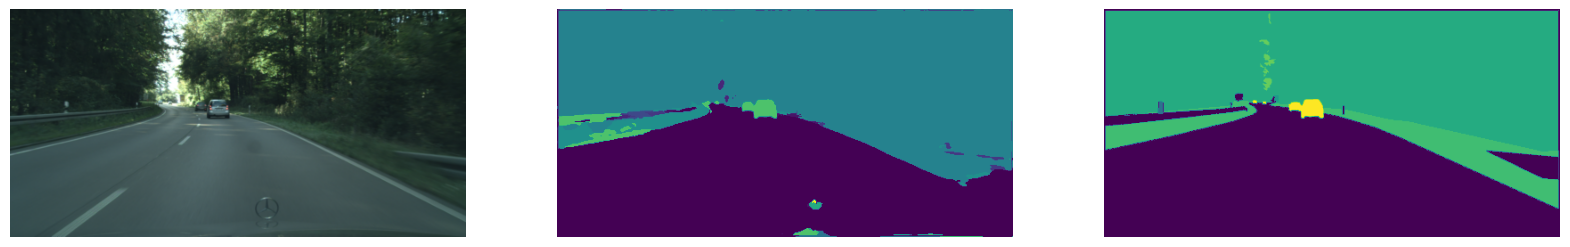

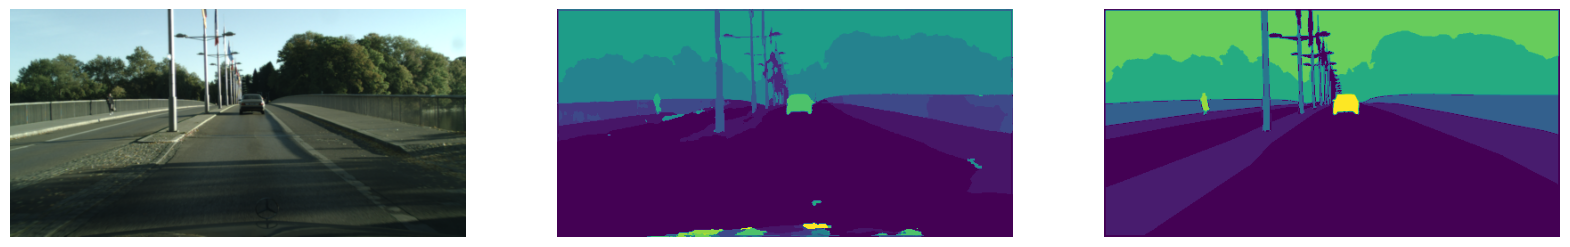

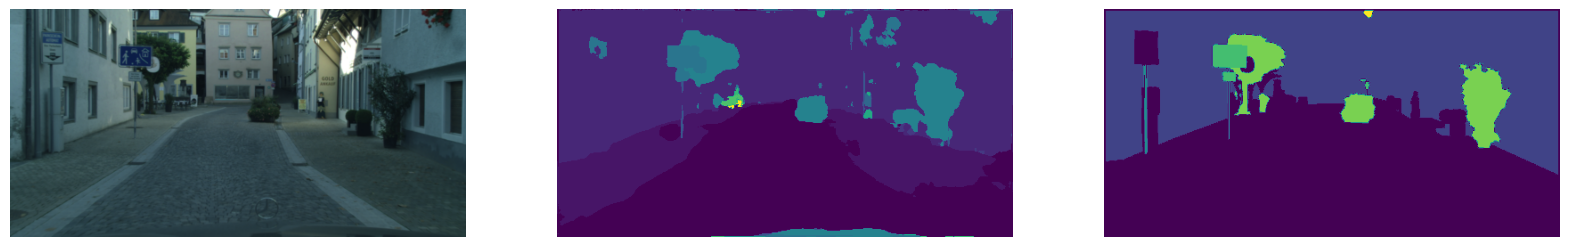

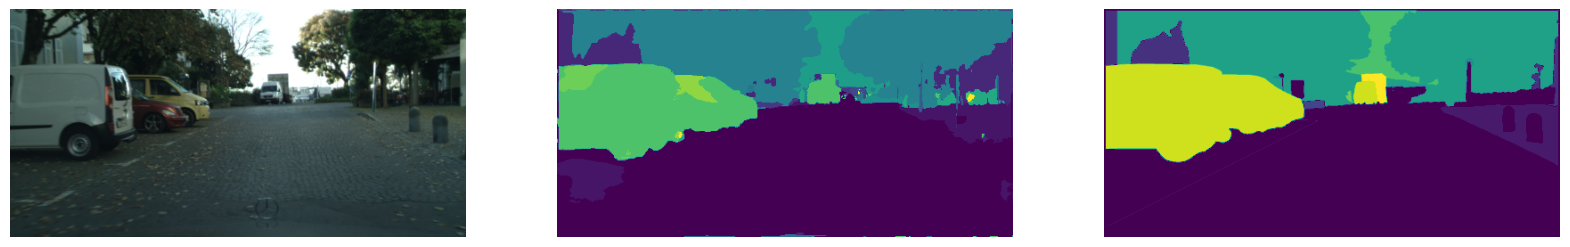

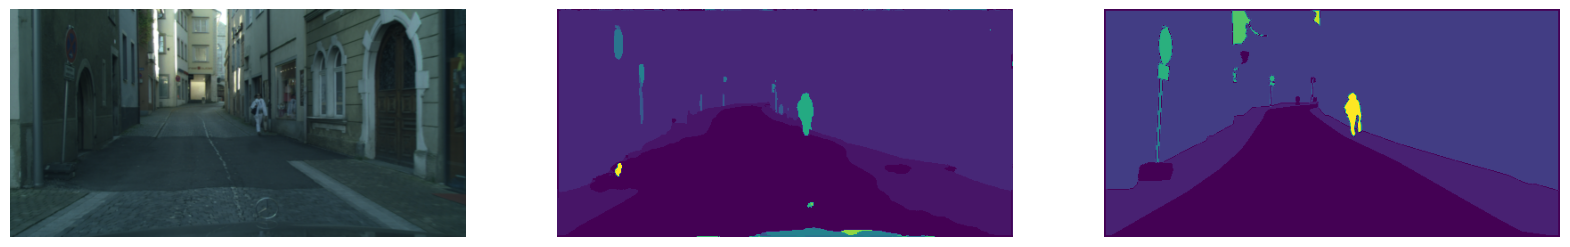

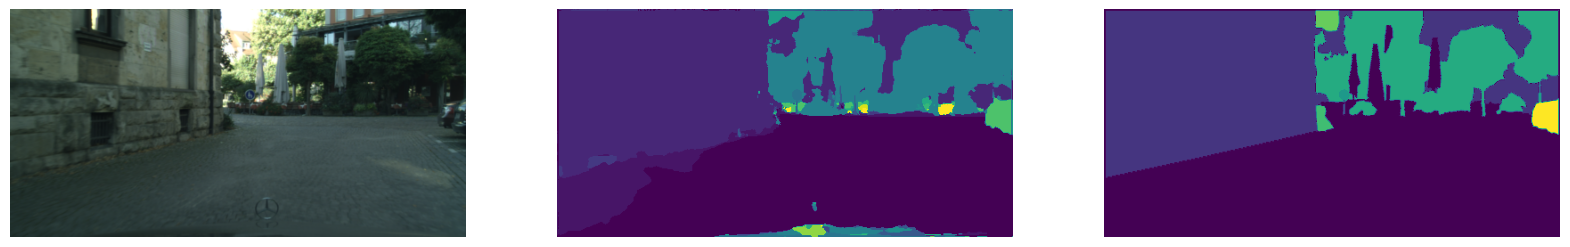

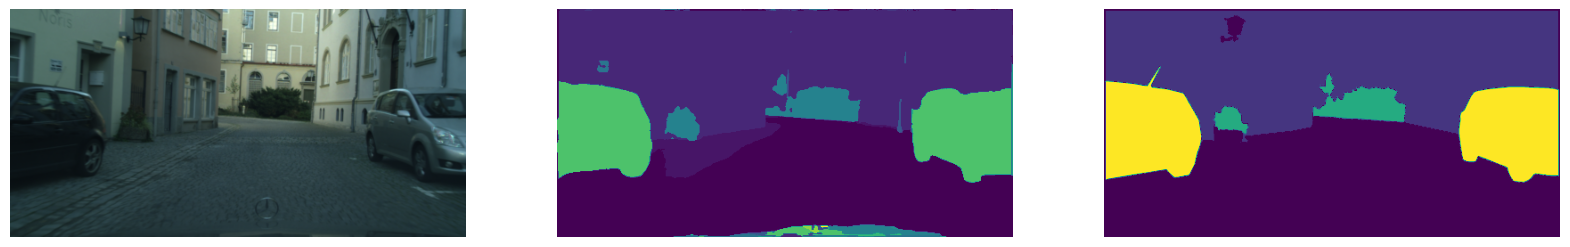

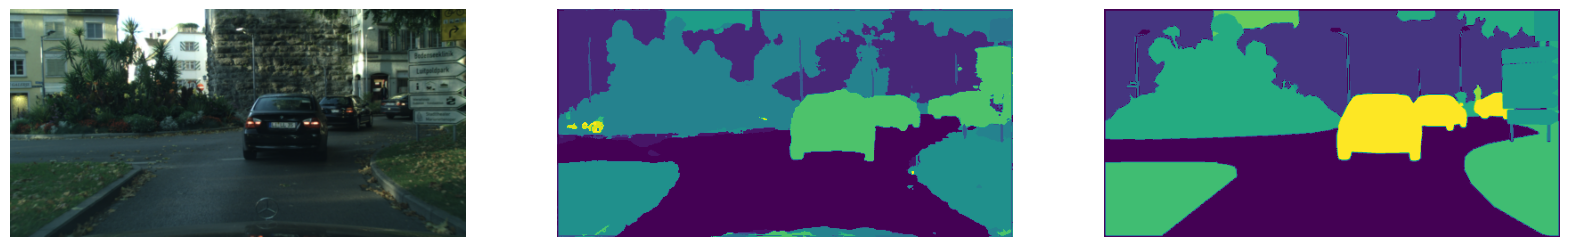

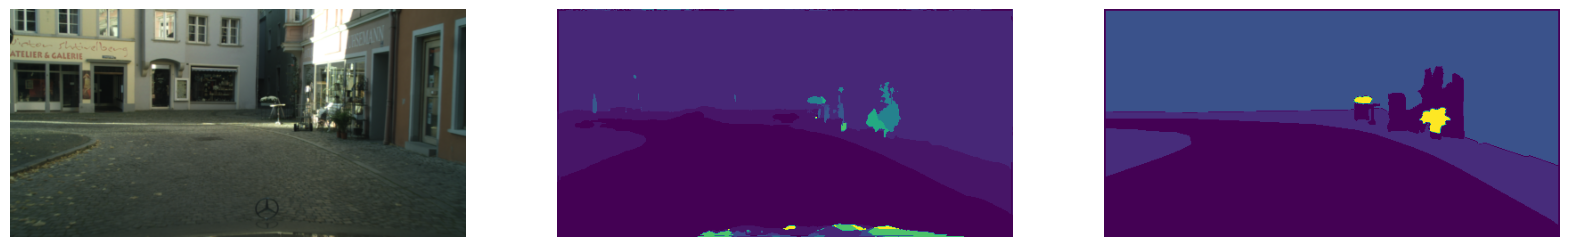

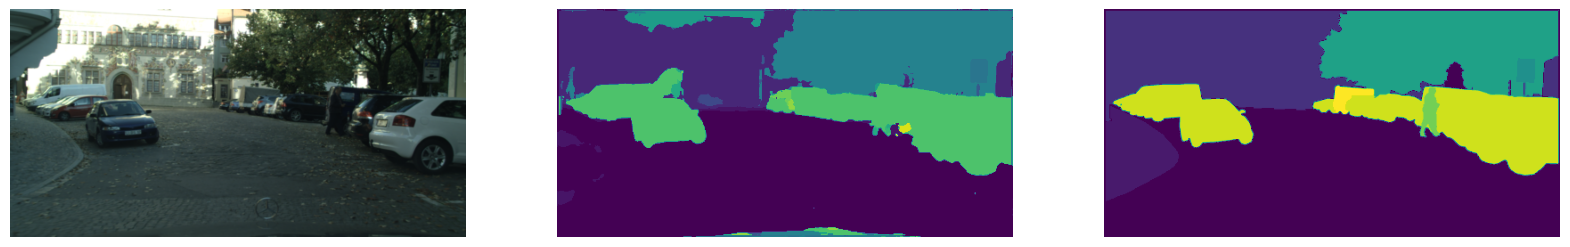

In [19]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = valid_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')

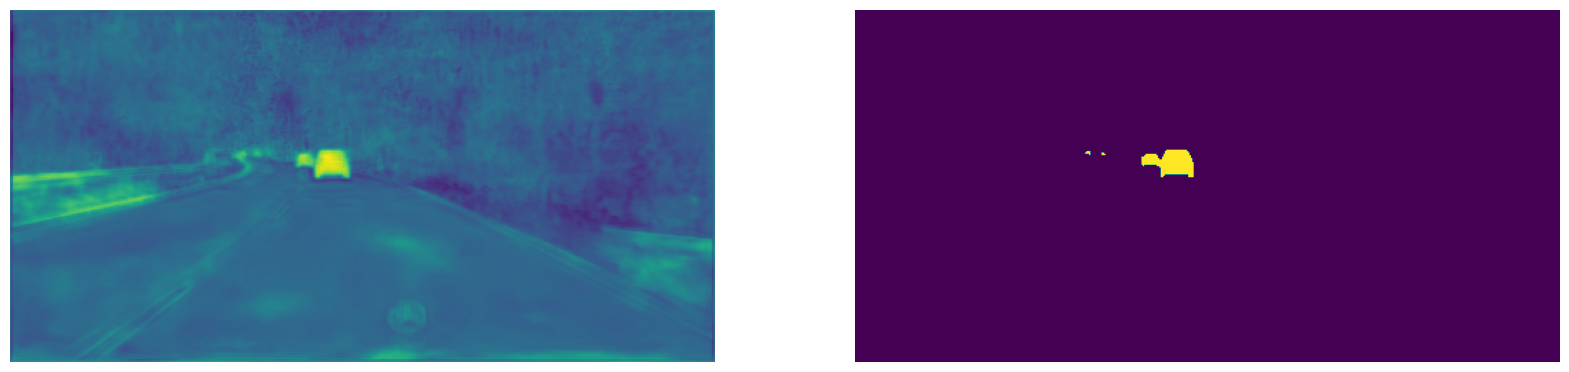

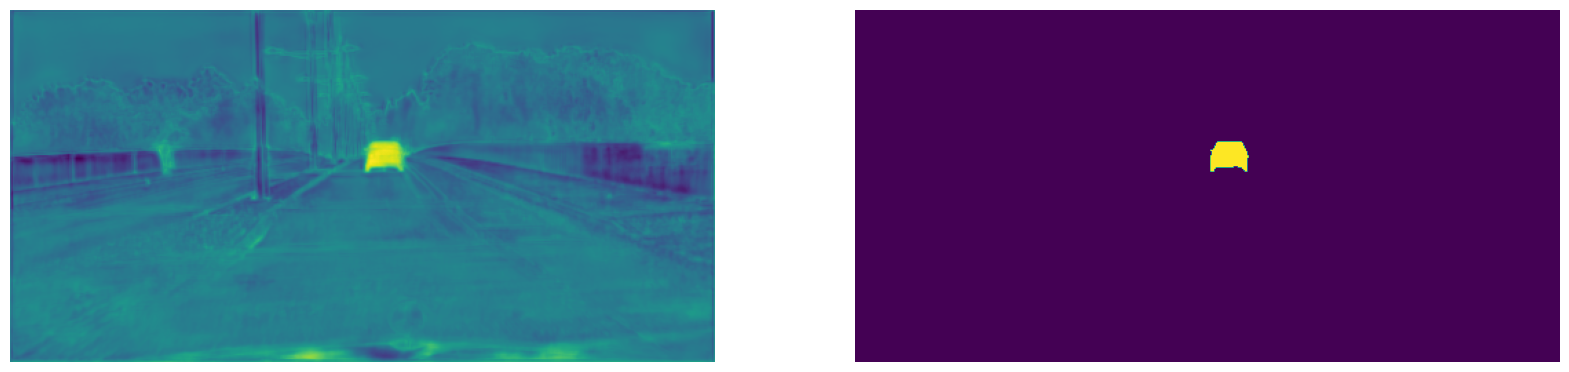

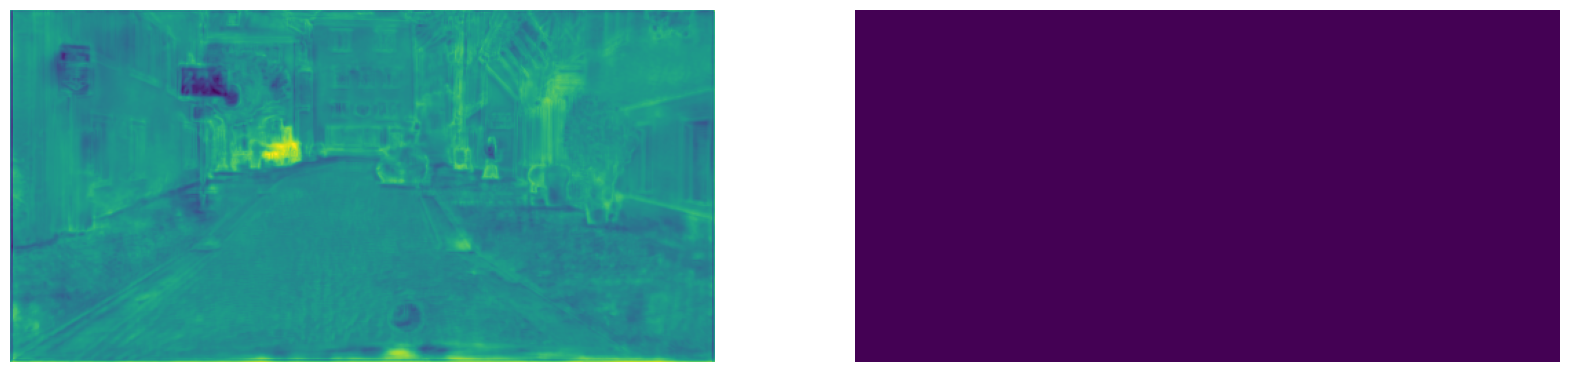

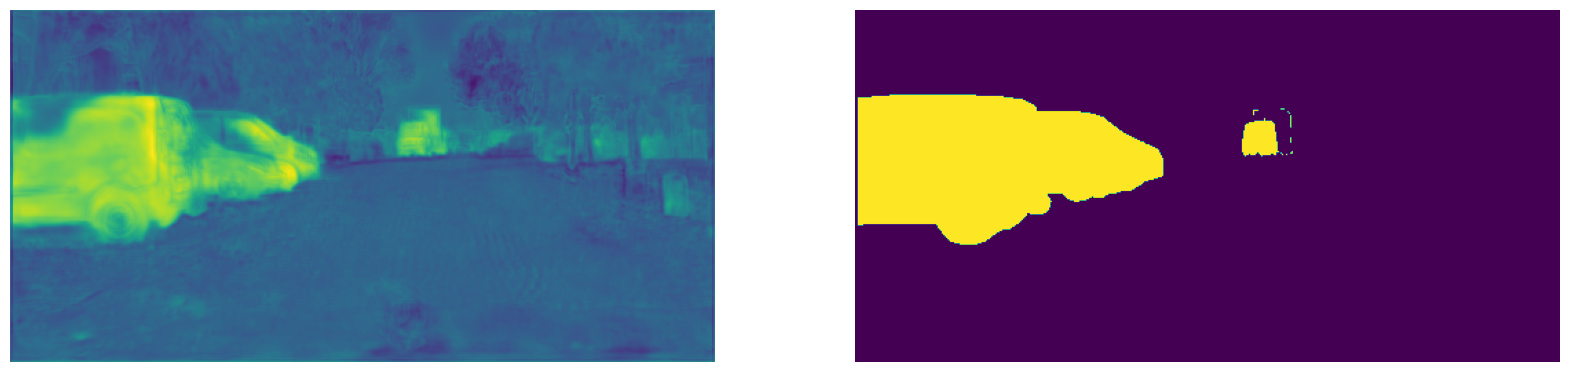

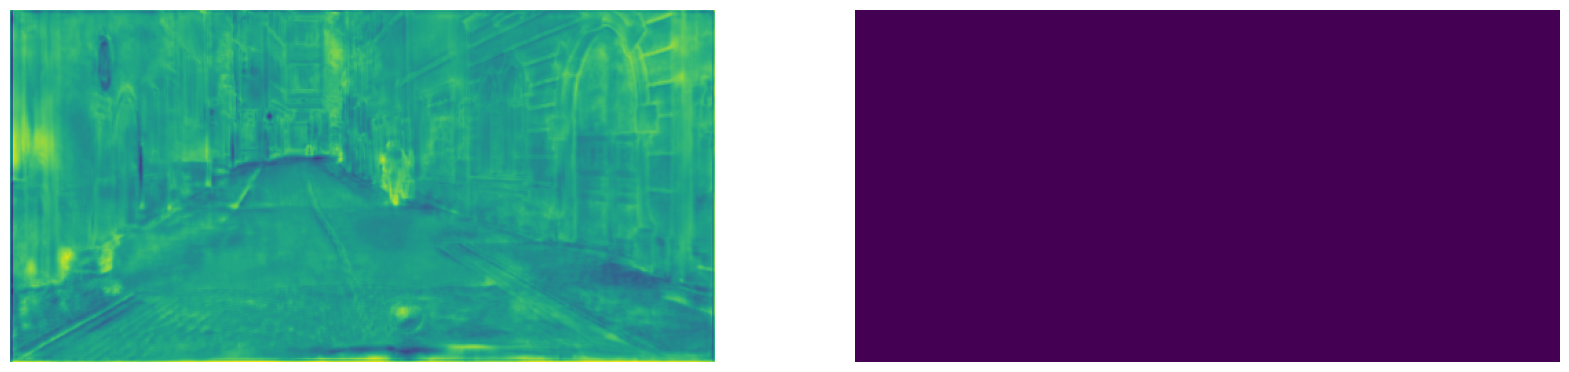

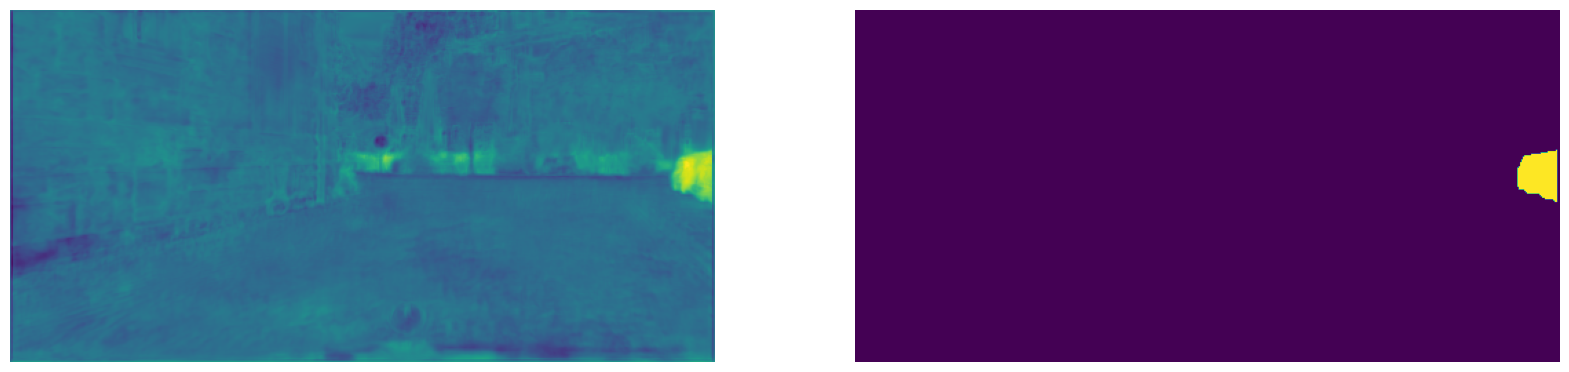

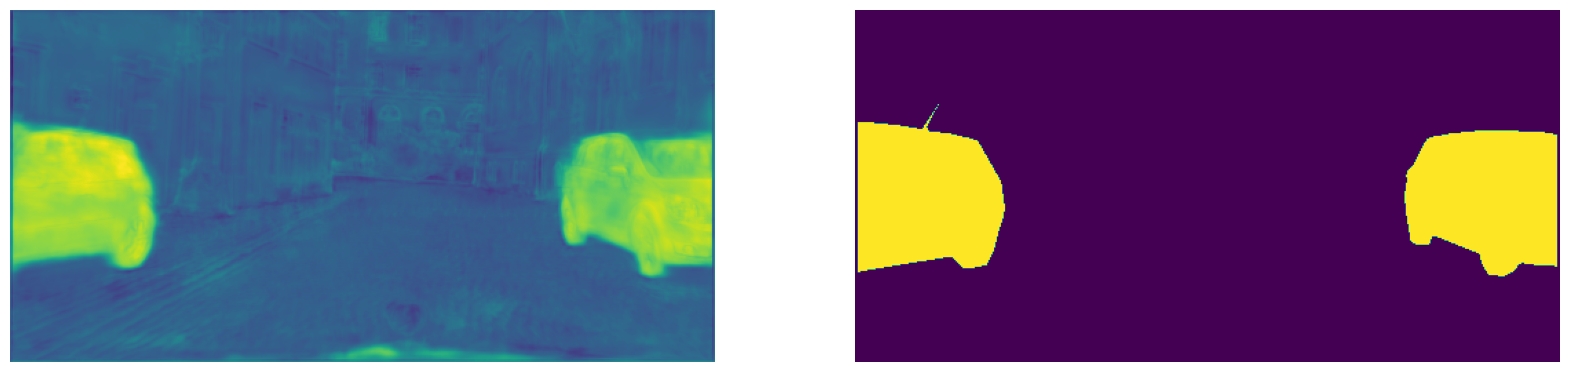

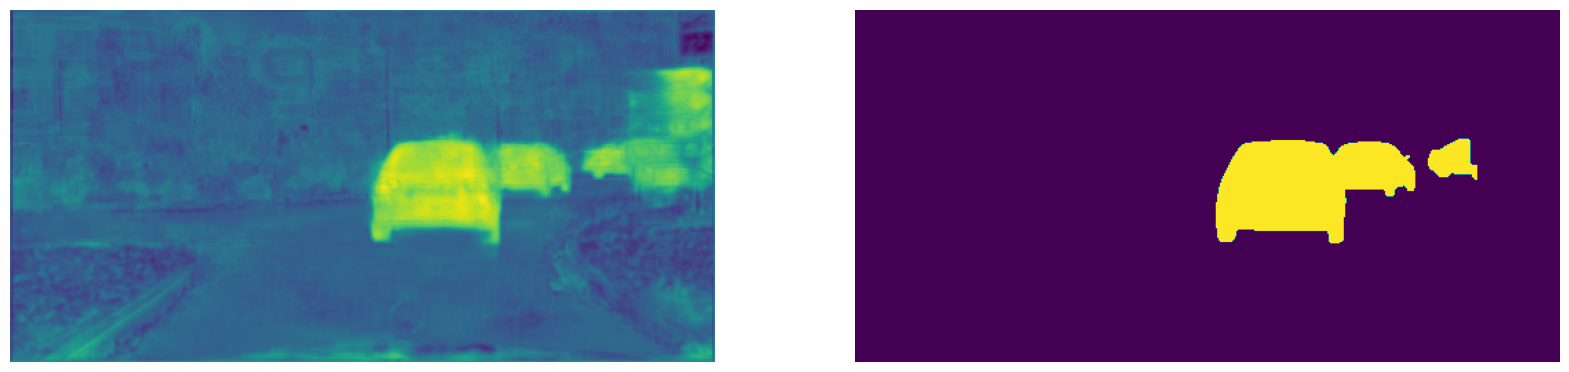

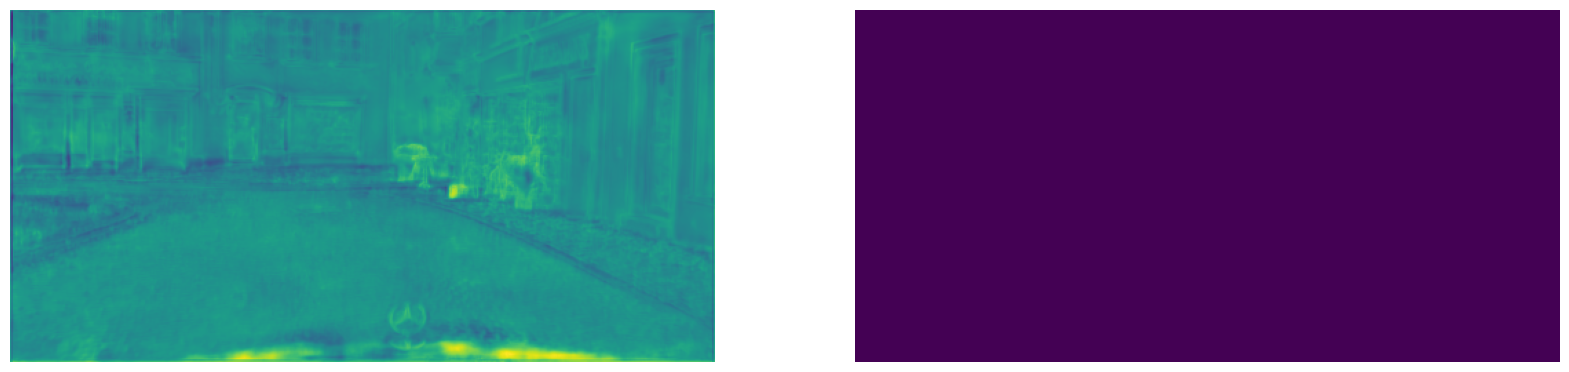

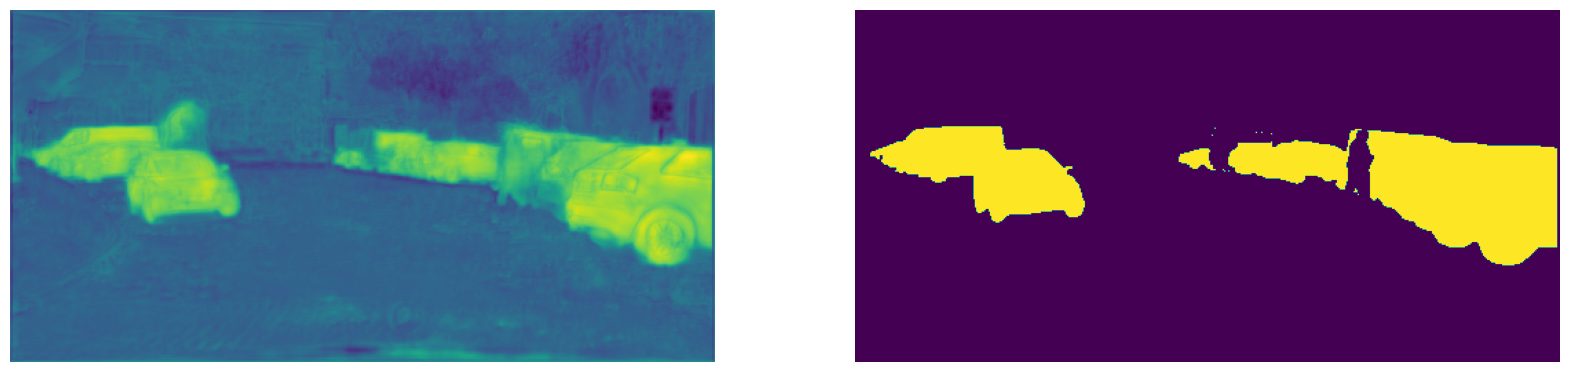

In [25]:
with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = valid_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)[0].cpu()

        f, axarr = plt.subplots(1, 2, figsize = (20,15))
        axarr[0].imshow(gen_mask[13].unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(valid_mask[13].unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')